# Introduction

According to Wikipedia, LinkedIn is a social media platform focused on business and employment launched in 2003. The platform is used for professional networking and carrer development at it stands as a digital labour market that allows job seekers to upload their CV, projects and achievements while employers posts jobs and vacancy. The platform is also used by companies/organisations to announce new products, upgrades and events.


This notebooks explores my personal LinkedIn  account in an attempt to discover patterns in my connections. The dataset was obtained from my LinkedIn account and will not be shared for the sake of privacy. Nonetheless,if youre interested in analysing your data yourself, [this medium artice](https://medium.com/bitgrit-data-science-publication/visualize-your-linkedin-network-with-python-59a213786c4) covered the step-by-step process of obtaining your own personal LinkedIn information. Don't worry prior knowledge of webscraping is not required to obtain data. In fact, even non-data nerds can obtain data from LinkedIn. 

# Question

1. When did I have the most connections?
2. Which company/organisation have the most connections with me?
3. Which position/role/job am i most connected with?
4. What is the connection between the positions I connect with and the companies/organisation?


# The Data

Importing the neccessary dependencies

In [2]:
pip install python-louvain

     ---------------------------------------- 0.0/204.6 kB ? eta -:--:--
     ------------- ------------------------- 71.7/204.6 kB 1.3 MB/s eta 0:00:01
     ------------------------ ------------- 133.1/204.6 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 204.6/204.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9403 sha256=b6c4b5dac5058fde76a0f9437e0b7005956226aaa99db61c01bc42ecf97a096e
  Stored in directory: c:\users\kafka\appdata\local\pip\cache\wheels\11\c1\e7\f62a211c636275e2da798bf0c307a3ae79aeddaf2524a03ce4
Successfully built python-louvain
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd 

#For Visualizations
import plotly.express as px 
import matplotlib.cm as cm
import matplotlib.pyplot as plt

#For Natural Language Processing and Text Analysis
import wordcloud 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


#For Network Analysis
import networkx as nx
import community.community_louvain as cl

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kafka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
#Import the data obtained from linked in
df = pd.read_csv('Connections_csv.csv', low_memory=False, encoding='utf-8')


# Getting to Know the Data

In [7]:
print('The number of rows in the data is', df.shape[0])
print('The number of columns in the data is', df.shape[1])

The number of rows in the data is 1237
The number of columns in the data is 7


In [8]:
df.columns 

Index(['First Name', 'Last Name', 'URL', 'Email Address', 'Company',
       'Position', 'Connected On'],
      dtype='object')

- First Name: The first name of my connection.

- Last Name: The last name of my connection.

- Email Address: The email address of my connection.

- Company: The company my connection works in.

- Position: This is the job description of my connection.

- Connected On:The date we connected.

In [9]:
df.info() #Getting details of the columns in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1237 entries, 0 to 1236
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   First Name     1227 non-null   object
 1   Last Name      1227 non-null   object
 2   URL            1227 non-null   object
 3   Email Address  30 non-null     object
 4   Company        1194 non-null   object
 5   Position       1195 non-null   object
 6   Connected On   1237 non-null   object
dtypes: object(7)
memory usage: 67.8+ KB


From the above, all of the dataset exists in the right format except the 'Connected On' column which was impoerted as an object instead of date.

In [10]:
df['Connected On'] = pd.to_datetime(df['Connected On'])
df['Connected On'] = df['Connected On'].dt.strftime('%Y-%m-%d')
df['Company'].astype(str)
df['Position'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1237 entries, 0 to 1236
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   First Name     1227 non-null   object
 1   Last Name      1227 non-null   object
 2   URL            1227 non-null   object
 3   Email Address  30 non-null     object
 4   Company        1194 non-null   object
 5   Position       1195 non-null   object
 6   Connected On   1237 non-null   object
dtypes: object(7)
memory usage: 67.8+ KB


C:\Users\kafka\AppData\Local\Temp\ipykernel_20228\1947952973.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Connected On'] = pd.to_datetime(df['Connected On'])


Handling the missing values.

In [11]:
df.isna().sum()

First Name         10
Last Name          10
URL                10
Email Address    1207
Company            43
Position           42
Connected On        0
dtype: int64

The missing value is mostly concentrated in the 'Email Address' column. The null values in the 'First Name' and 'Last Name' columns are 10. The 'Company' and 'Position' columns have the different numbers (43 and 42) of missing values. This might mean that the particular user haas either deleted his/her account or did not give any information when registering the account. This hypothesis is tested below:

In [12]:

df.loc[df['First Name'].isna()]

First Name Last Name  URL Email Address Company Position Connected On
212         NaN       NaN  NaN           NaN     NaN      NaN   2023-12-04
356         NaN       NaN  NaN           NaN     NaN      NaN   2023-09-14
648         NaN       NaN  NaN           NaN     NaN      NaN   2023-06-16
652         NaN       NaN  NaN           NaN     NaN      NaN   2023-06-16
694         NaN       NaN  NaN           NaN     NaN      NaN   2023-05-10
849         NaN       NaN  NaN           NaN     NaN      NaN   2023-01-10
931         NaN       NaN  NaN           NaN     NaN      NaN   2022-10-26
932         NaN       NaN  NaN           NaN     NaN      NaN   2022-10-26
996         NaN       NaN  NaN           NaN     NaN      NaN   2022-02-26
1189        NaN       NaN  NaN           NaN     NaN      NaN   2020-11-02

It can be seen that values with missing 'First Name' have missing values for all columns  except 'Connected On'. This proves my hypothesis to be correct. The same is also true for Company and Position.

In [13]:
df.drop(['Email Address', 'Last Name'], axis=1, inplace=True)


In [14]:
df.dropna(subset=['Company', 'Position'], inplace=True)

In [15]:
print('Is there any missing values remaining?',df.isna().sum().any())
print('The shape of the dataset after dropping the missing values is', df.shape)

Is there any missing values remaining? False
The shape of the dataset after dropping the missing values is (1194, 5)


# 1. When did I have the most connections?

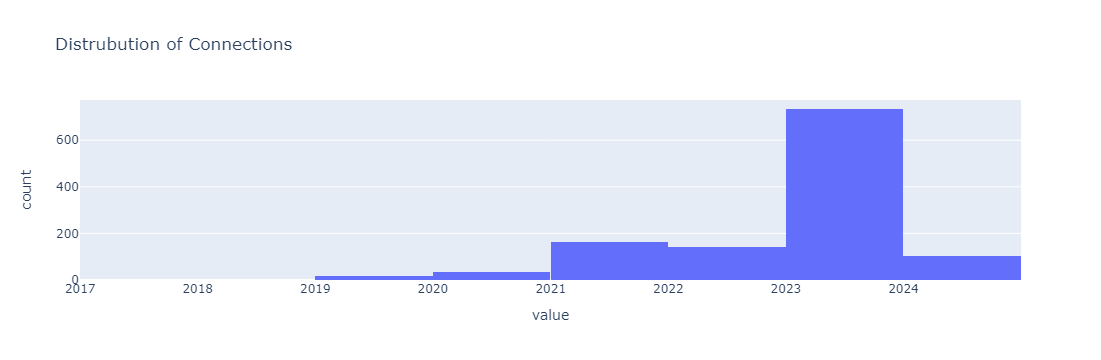

In [16]:
fig = px.histogram(df['Connected On'], nbins=10, title= 'Distrubution of Connections')
fig.update_layout(showlegend=False)

From the histogram above, I had the most connections between January 2023 to December 2023. It can also be seen, that I have not been active recently.

# 2. Which company/organisation have the most connections with me?

In [17]:
company_position = df[['Company', 'Position']
                     ].groupby(by="Company"  #group company and position by company
                              ).count().sort_values(by="Position", ascending =False).head(10) 
company_position

Position
Company                                        
EY                                           62
Deloitte                                     43
KPMG India                                   39
Accenture                                    25
PwC India                                    18
PwC                                          15
Tata Consultancy Services                    14
Indian Institute of Technology, Mandi        13
JPMorgan Chase & Co.                         11
Redseer Strategy Consultants                  9

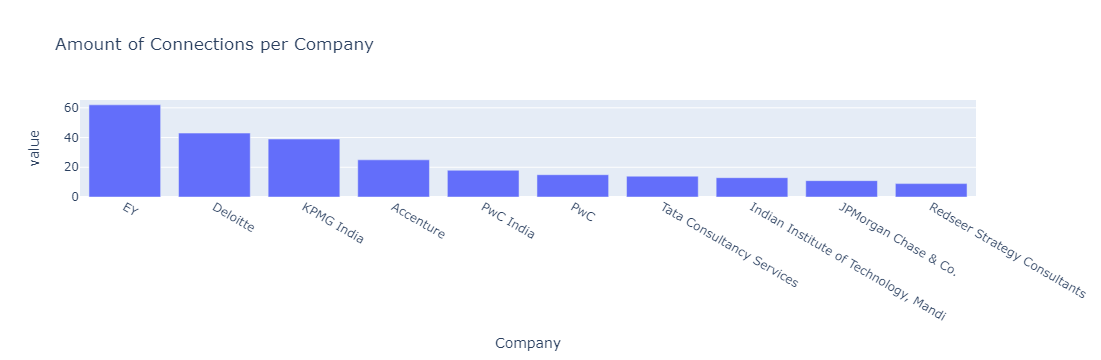

In [18]:
fig=px.bar(company_position, title='Amount of Connections per Company')
fig.update_layout(showlegend=False)

From the bar chart above, it,s clear that EY has the highest number of connection followed by Deloitte and so on.
The bar chart give little information about the companies/organisations with the highest connections. This is because different people have different ways of identifying the same organisation and the different departments in the organisation will not be ientified as one. For example, from the bar chart, one can see that 'PwC India' and 'PwC' were identified as two different organisations. Also they are also organisations within PwC.

This requires further analysis using the word cloud.


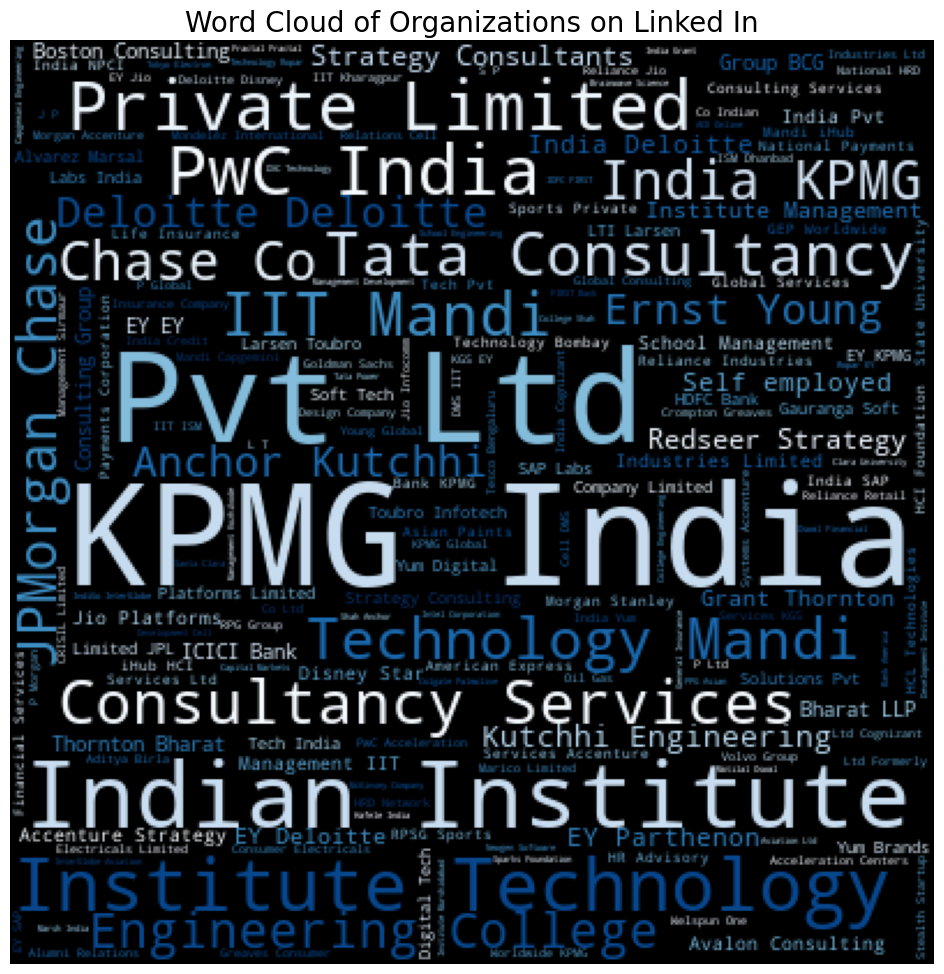

In [19]:
import wordcloud 
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
df['Company_no_stopwords'] = df['Company'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in df['Company_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)

plt.subplots(figsize = (12,12))
word = wordcloud.WordCloud(collocation_threshold=4,
                           background_color='black', 
                           width=400, 
                           height=400,
                           colormap='Blues_r').generate(all_words_str)
font_size = 20
plt.imshow(word)
plt.axis('off')
plt.title('Word Cloud of Organizations on Linked In', fontdict={'fontsize': font_size})
plt.savefig('LinkedIn-Word-Clouds.png')
plt.show()

The word cloud also show that the KPMG India has the highest frequency.

# 3. Which position/role/job am i most connected with?

In [20]:
df_by_pos = df.groupby(by='Position').count().reset_index().sort_values('First Name', ascending=False)
df_by_pos

Position  First Name  URL  \
495                                            Partner          40   40   
238                                           Director          36   36   
434                                            Manager          20   20   
178                                         Consultant          18   18   
62                                  Associate Director          16   16   
..                                                 ...         ...  ...   
291                                  Firmware Engineer           1    1   
293                                      Founder & CEO           1    1   
294                                 Founder & Director           1    1   
295  Founder -CP HR Advisory ; Managing Partner - K...           1    1   
803                      operations / customer service           1    1   

     Company  Connected On  Company_no_stopwords  
495       40            40                    40  
238       36            36                    36  
434       20            20                    20  
178       18            18                    18  
62        16            16                    16  
..       ...           ...                   ...  
291        1             1                     1  
293        1             1                     1  
294        1             1                     1  
295        1             1                     1  
803        1             1                     1  

[804 rows x 6 columns]

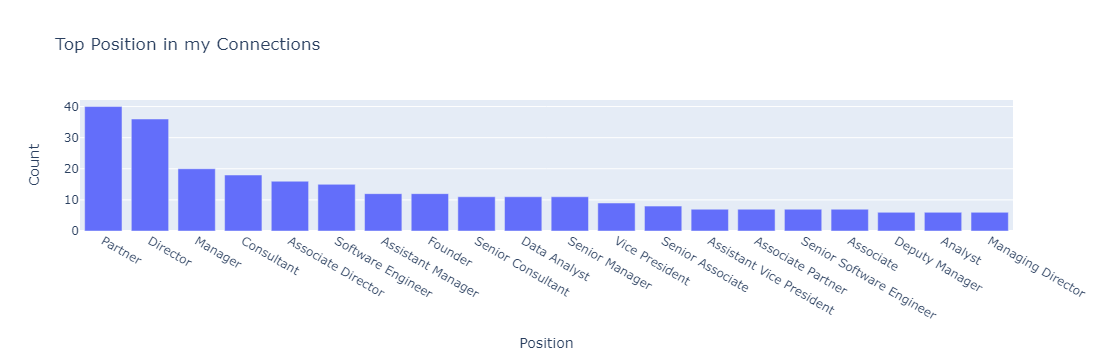

In [21]:
px.bar(df_by_pos[:20], x='Position', y='First Name', labels={'First Name': 'Count'}, title= 'Top Position in my Connections')

In [22]:
df['Position'].unique()

array(['Director - Merchandising', 'Recruiter',
       'HR and Innovation Practice Lead(5G and 6G Technology)',
       'Lt Gen Indian Army Veteran', 'Research Internship',
       'Associate Partner', 'Strategy Senior Manager',
       'Hon. National President ', 'Operation Director',
       'Partner and Vice President', 'Senior Manager', 'Partner',
       'Management Consulting Analyst', 'Associate Director',
       'WSS - Pidilite Roff - Delhi',
       'President and Managing Director - Indian Subcontinent',
       'Director', 'Manager',
       'Director, Human Capital Consulting at Deloitte & Touche (M.E)',
       'Manager - HR Transformation', 'Talent Development Manager',
       'Marketing Research Intern', 'AVP, Growth',
       'EY Global Deputy Vice Chair, Strategy and Transactions',
       'Senior Director', 'Chief Growth Officer',
       'On Leave to Pursue MBA', 'Management Trainee',
       'Student Programs Recruiter', 'Program Manager',
       'Senior Bid Manager - Asia Pacif

It is also important to check the amount of connections related to my area of interest. Because of the isssues faced when analyzing connections. A different approach will be taken. We  check if the positions contains strings related to data science/anlalytical roles and compare them with other areas of interests,

In [44]:
a = [
     'Research Related Roles',
     'Economics Related Roles',
     'Analyst Related Roles',
     'Data Science Related Roles', 
     'Data Related Roles',
     'Finance Related Roles',
     'Statistics Related Roles',
     'Intern'
    ]
b = [
     df["Position"].str.contains("Research").sum(),
     df["Position"].str.contains("Economi").sum(),
     df["Position"].str.contains("Analyst").sum(),
     df["Position"].str.contains("Data Scientist").sum(),
     df["Position"].str.contains("Data").sum(),
     df["Position"].str.contains("Financ").sum(),
     df["Position"].str.contains("Statistic").sum(),
     df["Position"].str.contains("Intern").sum()]
most_significant = pd.DataFrame({'roles':a, 'count': b}).sort_values('count', ascending=False)  
most_significant

roles  count
2       Analyst Related Roles     77
7                      Intern     51
4          Data Related Roles     46
0      Research Related Roles     26
5       Finance Related Roles     12
3  Data Science Related Roles      7
1     Economics Related Roles      0
6    Statistics Related Roles      0

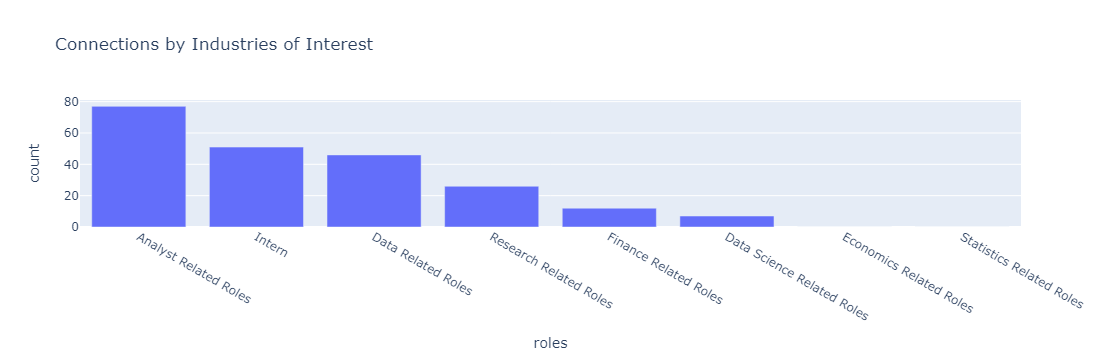

In [43]:
px.bar(most_significant, x='roles',y='count', title='Connections by Industries of Interest')

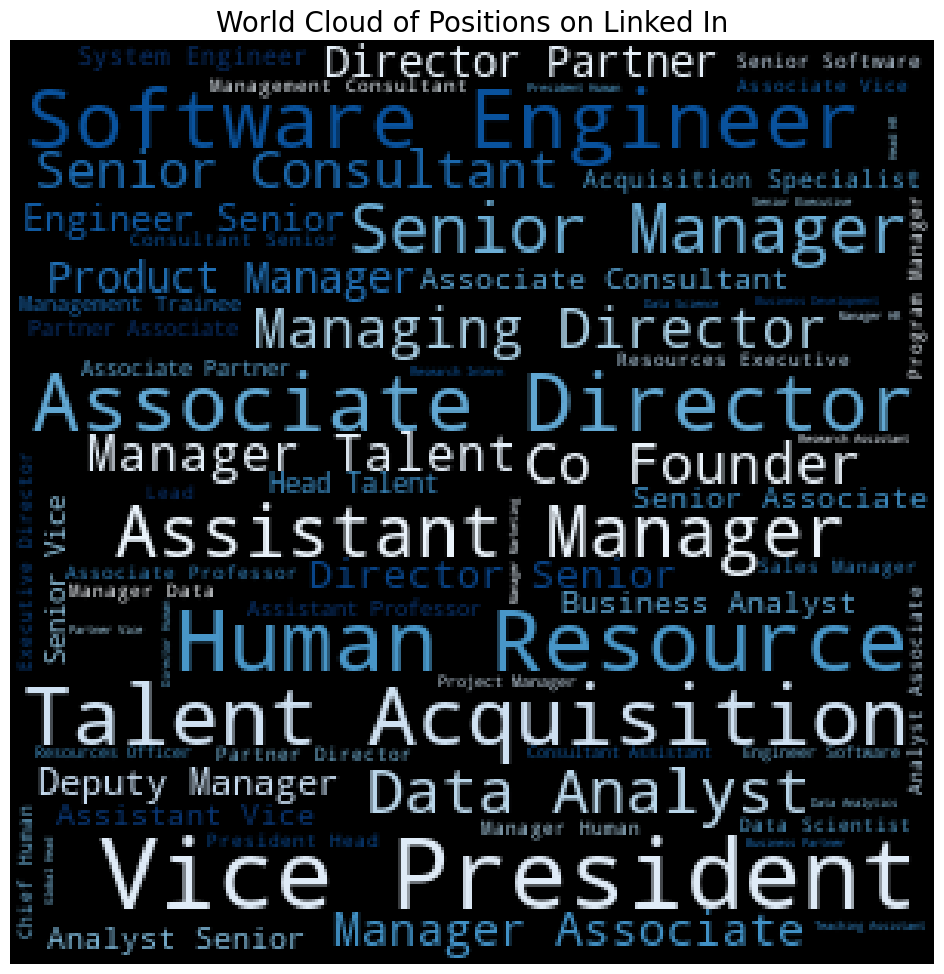

In [25]:
df['position_no_stopwords'] = df['Position'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words_in_position = list([a for b in df['position_no_stopwords'].tolist() for a in b])
all_words_pos = ' '.join(all_words_in_position)

plt.subplots(figsize = (12,12))
word_pos = wordcloud.WordCloud(collocation_threshold=3,
                               background_color='black', 
                               width=300, 
                               height=300,
                               colormap='Blues').generate(all_words_pos)
font_size = 20
plt.imshow(word_pos)
plt.axis('off')
plt.title('World Cloud of Positions on Linked In', fontdict={'fontsize': font_size})
plt.savefig('LinkedIn-Word-Cloud.png')
plt.show()

From the word cloud, it can be seen that Associate Director, Vice President, Software Engineer and co founder are common occupation of my connections.

# 4. What is the connection between the positions I connect with and the companies/organisation

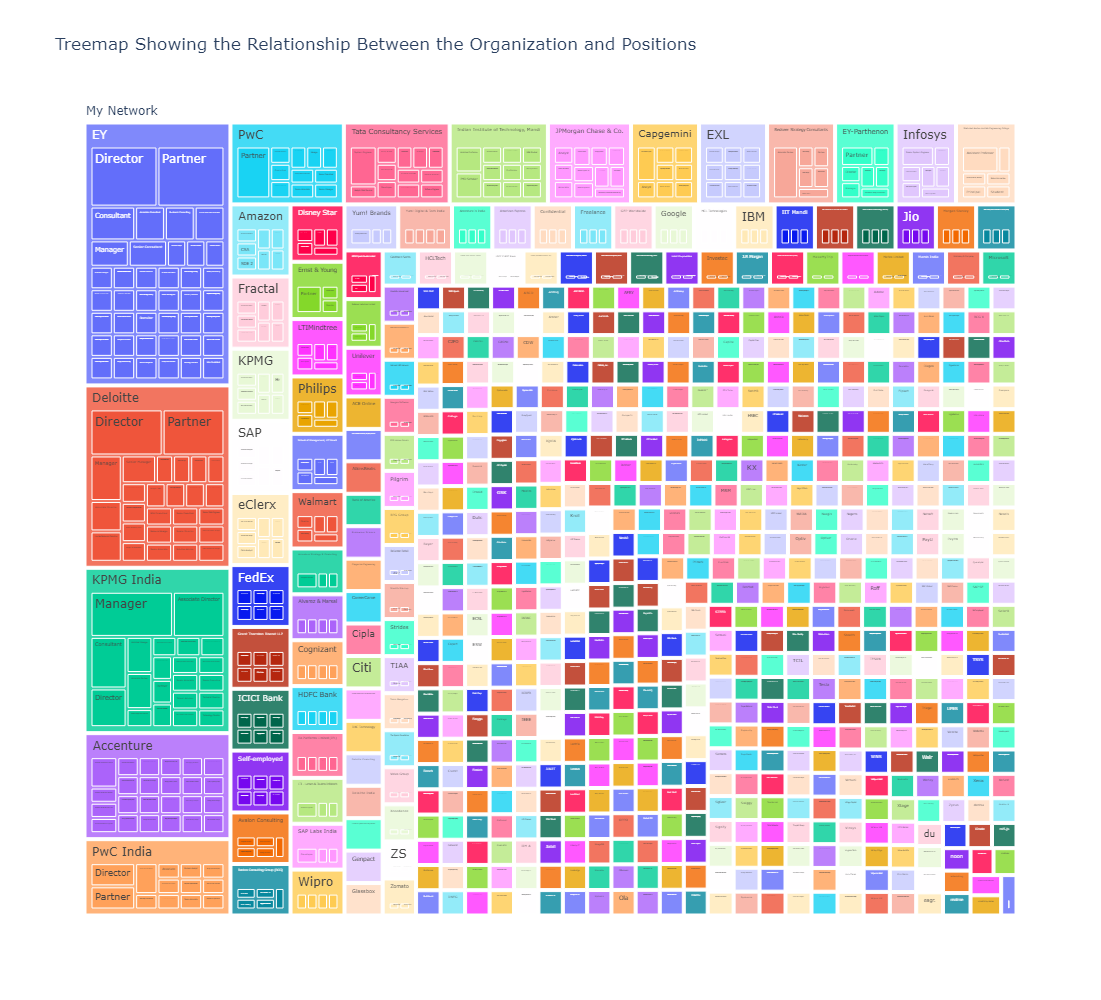

In [26]:
df['My Network'] = 'My Network'
fig = px.treemap(df, 
                 path=['My Network', 'Company', 'Position'],
                 width=1000, 
                 height=1000,
                 title= 'Treemap Showing the Relationship Between the Organization and Positions')
fig.show()

This shows the various positions in each company. For example, under EY, I am connected to Director, Partners, Consultants etc.
We can also check the company with different positions:

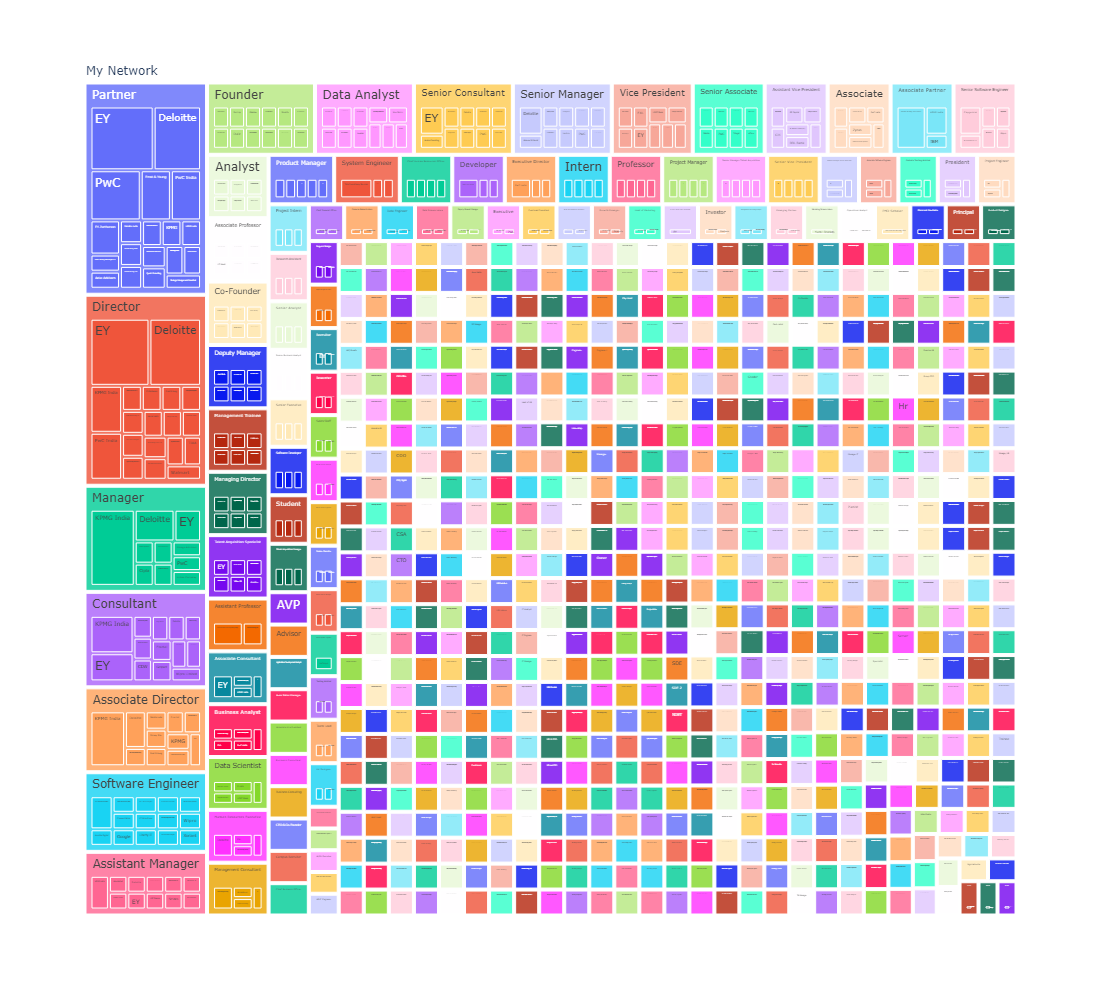

In [27]:
fig = px.treemap(df, path=['My Network', 'Position', 'Company'], width=1000, height=1000)
fig.show()

The treemap shows the positions I am connected to in each organisation. But the web of relationship between the organisations and positions remains unclear.
To answer this, I will use network charts. A network is a map that shows relationship between different objects.

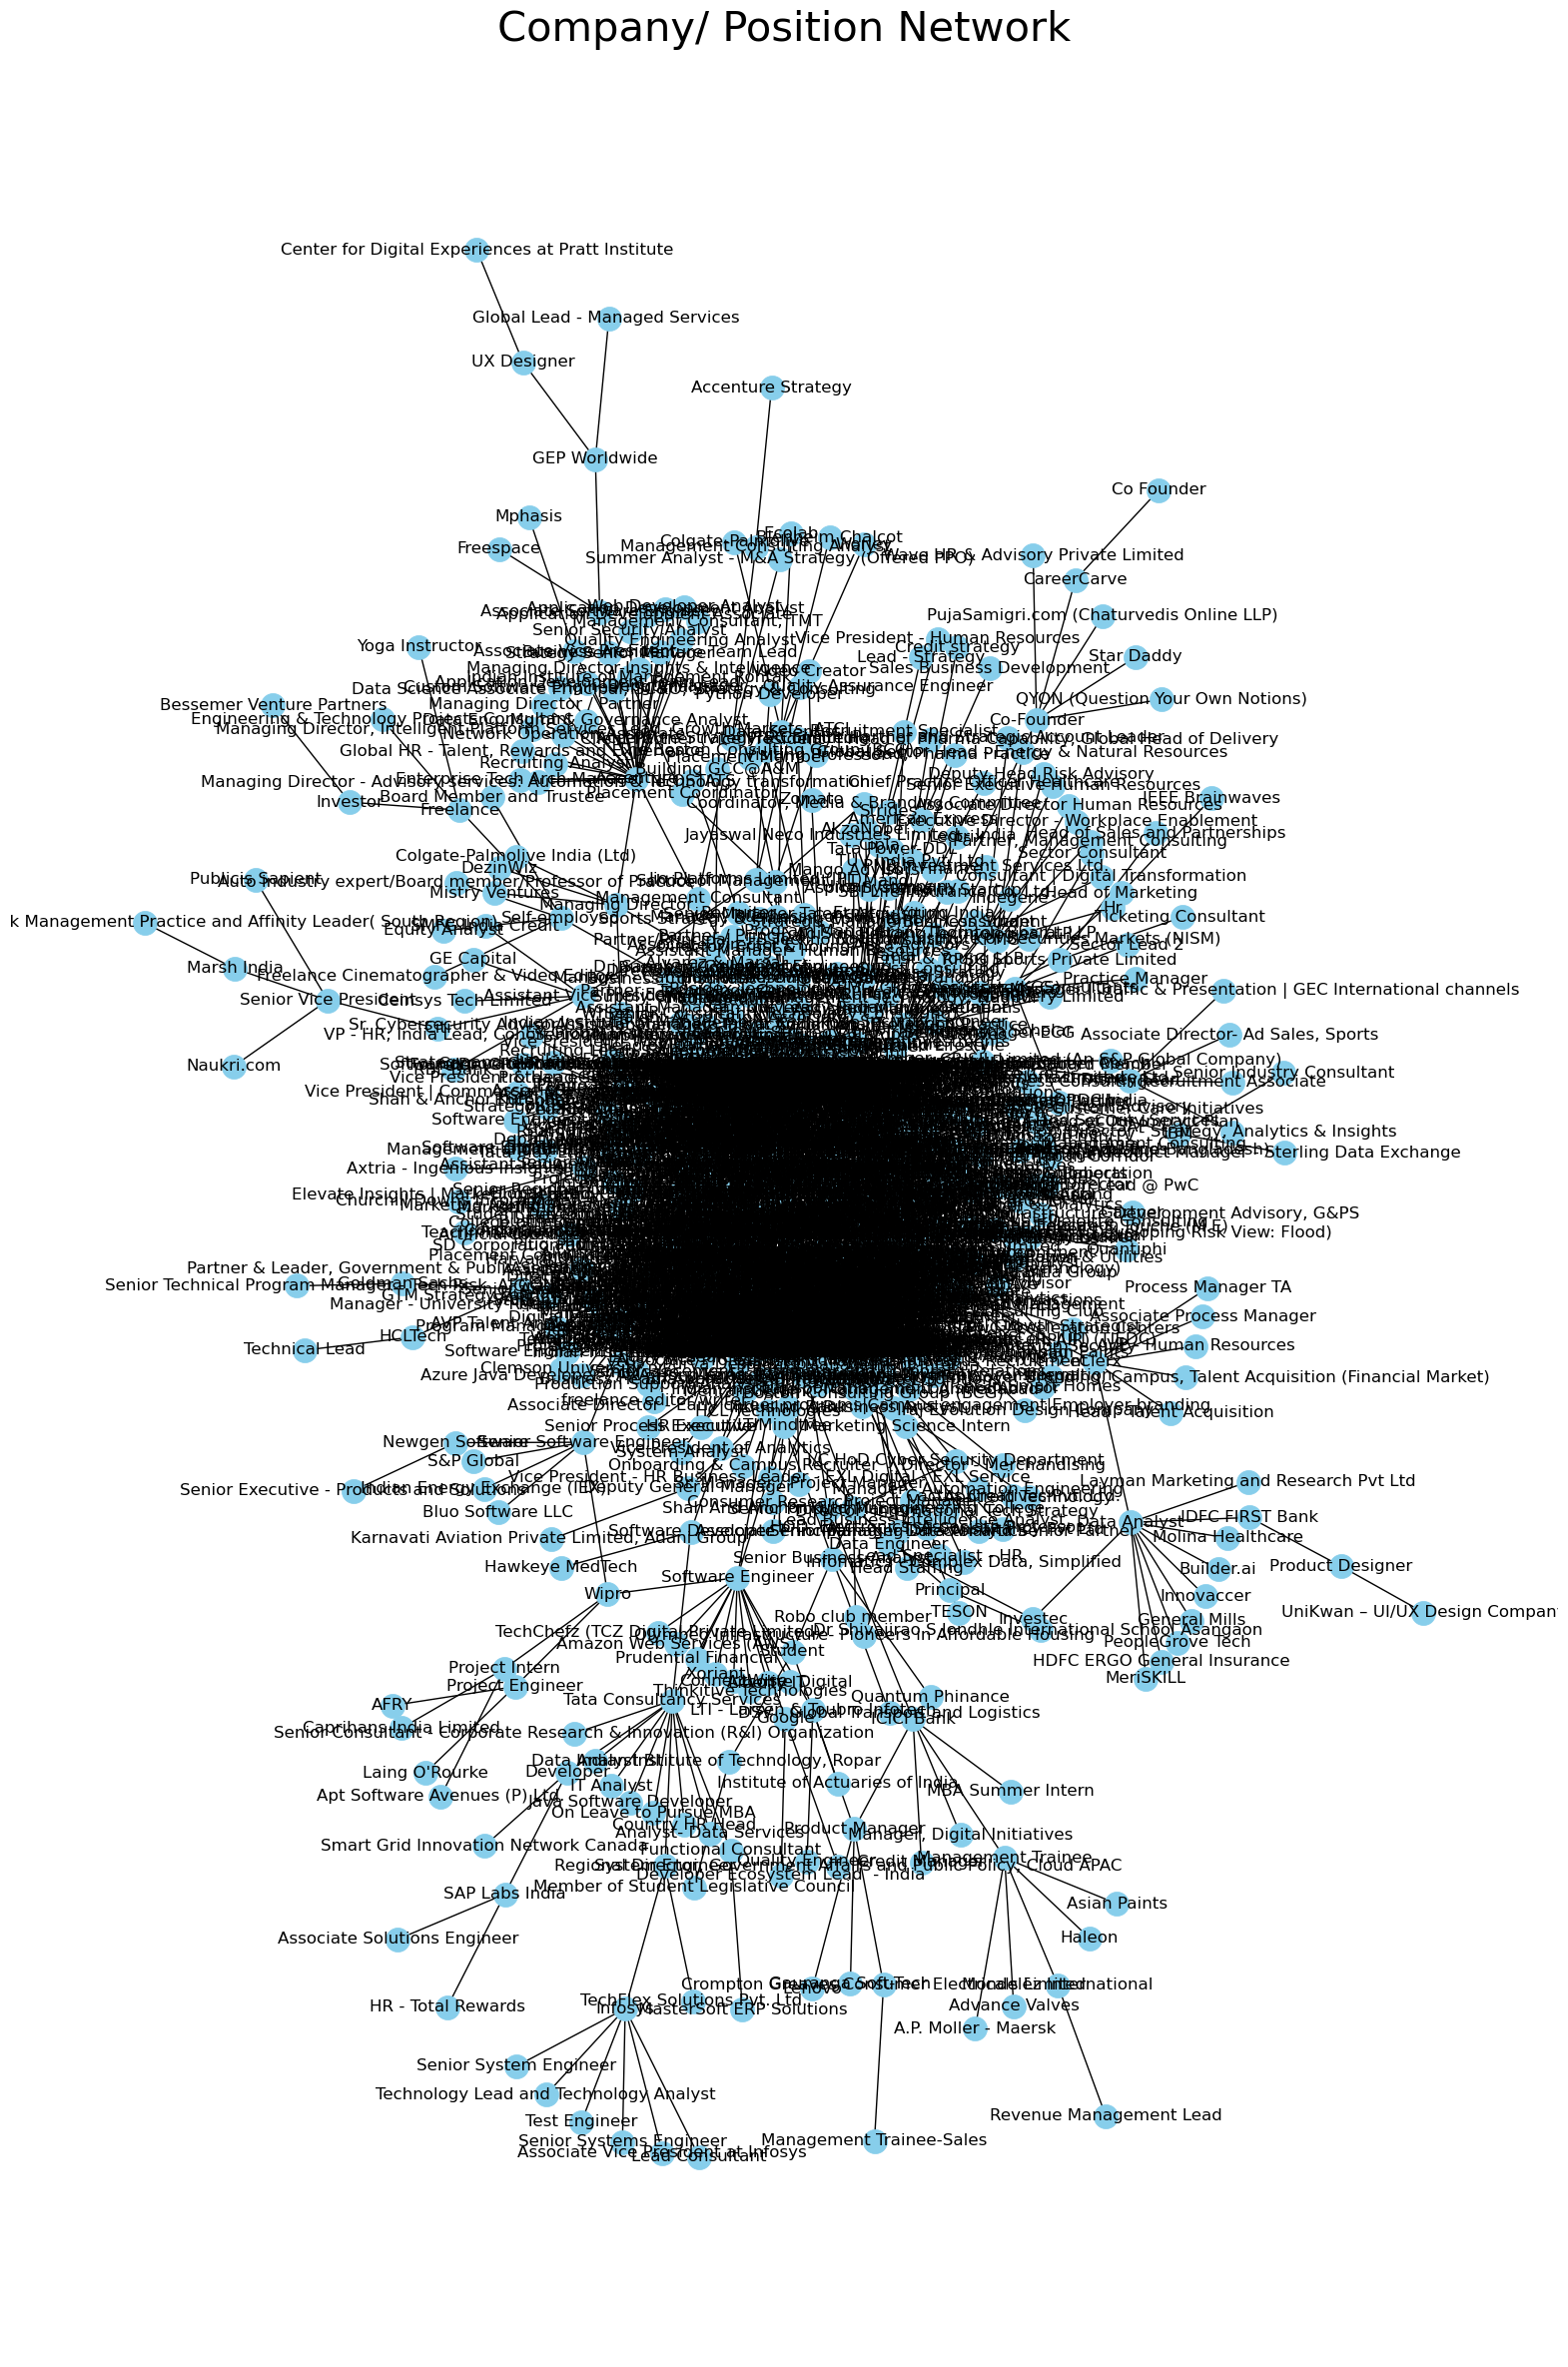

In [28]:

G = nx.from_pandas_edgelist(df,source= 'Position', target='Company', edge_attr=True, create_using=nx.Graph())

plt.rcParams['figure.figsize']  = (20, 30)
plt.style.use('ggplot')
plt.title('Company/ Position Network', fontsize = 30)
plt.grid()
plt.axis('off')



pos=nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=cm.Blues, pos=pos)
plt.show()

This looks messy and unclear. Let's try that again with pyvis.

In [29]:
!pip install pyvis

   ---------------------------------------- 0.0/756.0 kB ? eta -:--:--
   --------------- ------------------------ 297.0/756.0 kB 9.0 MB/s eta 0:00:01
   -------------------------------- ------- 614.4/756.0 kB 7.6 MB/s eta 0:00:01
   ---------------------------------------- 756.0/756.0 kB 6.8 MB/s eta 0:00:00


In [31]:
#!pip install pyvis (if not installed previously)
from pyvis.network import Network
net = Network(notebook= True,cdn_resources='in_line', width="1000px", height="700px", bgcolor='#222222', font_color='white')
node_degree = dict(G.degree)
nx.set_node_attributes(G, node_degree, 'size')
net.from_nx(G)
net.show('linked.html')


linked.html


Although Networks showed a lot of leaves and nodes, the pyvis visualisation shows that we have a a somewhere highly connected network  but in other places not much connected network.

We can check for the degree centrality of the network. Degree centrality shows the number of connections a node has.

In [32]:
degree_dict = nx.degree_centrality(G)
degree_dict

{'Director - Merchandising': 0.0006565988181221273,
 'Walmart': 0.0032829940906106366,
 'Recruiter': 0.0013131976362442547,
 'NEOSTATS': 0.0006565988181221273,
 'HR and Innovation Practice Lead(5G and 6G Technology)': 0.0006565988181221273,
 'Jio Platforms Ltd': 0.0006565988181221273,
 'Lt Gen Indian Army Veteran': 0.0006565988181221273,
 'Indian Army': 0.0006565988181221273,
 'Research Internship': 0.0006565988181221273,
 'IIT Kharagpur': 0.0006565988181221273,
 'Associate Partner': 0.001969796454366382,
 'IBM': 0.001969796454366382,
 'Strategy Senior Manager': 0.0006565988181221273,
 'Accenture': 0.015758371634931056,
 'Hon. National President ': 0.0006565988181221273,
 'National HRD Network': 0.0013131976362442547,
 'Operation Director': 0.0006565988181221273,
 'Jabil': 0.0006565988181221273,
 'Partner and Vice President': 0.0006565988181221273,
 'Complete Circle Capital Pvt. Ltd.': 0.0006565988181221273,
 'Senior Manager': 0.006565988181221273,
 'Indegene': 0.0006565988181221273,
 

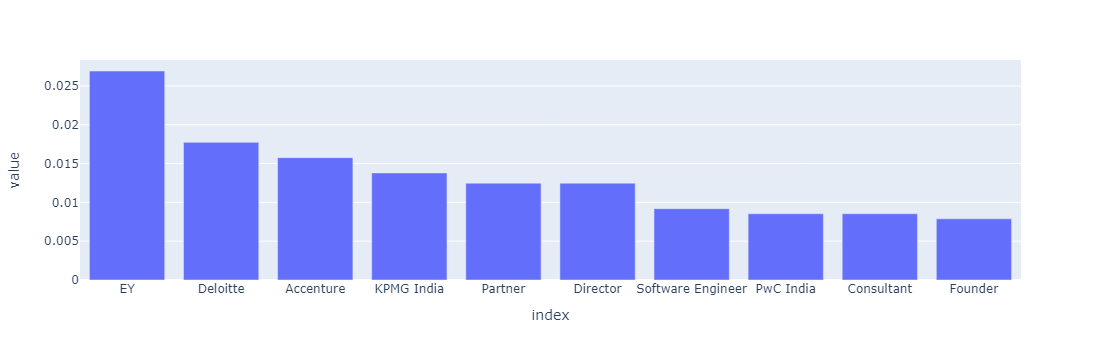

In [33]:
degree_df=nx.degree_centrality(G)
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
fig = px.bar(degree_df.sort_values('centrality', ascending=False).head(10))
fig.update_layout(showlegend=False)

This shows that EY has the most number of connections (nodes), followed by side Deloitte and Accenture. These were also the top to organization and positions in my network.

Let's check if our result emains consistent with other measures of centrality.
* Betweeness Centrality checks how a nodes serves as a broker between other nodes. That is, how much time a node serves as a bridge among the shortest path between two other nodes.
Closeness Centrality shows how fast a node can pass information within a network.

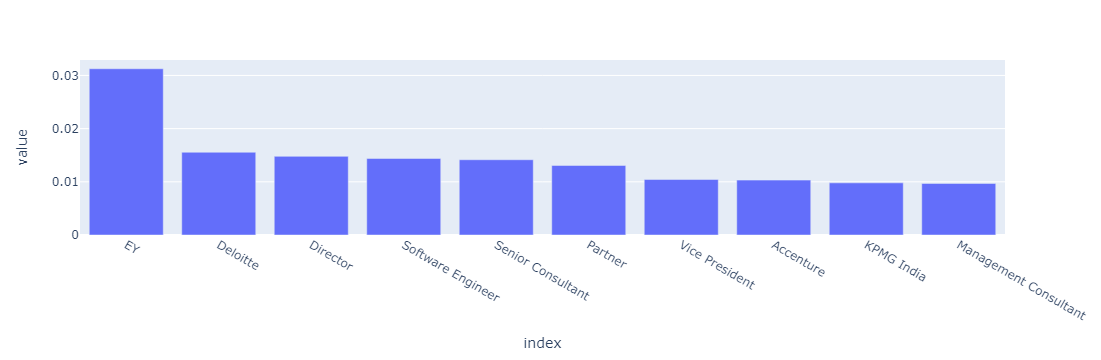

In [34]:
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])

fig = px.bar(betweenness_df.sort_values('centrality', ascending=False).head(10))
fig.update_layout(showlegend=False)

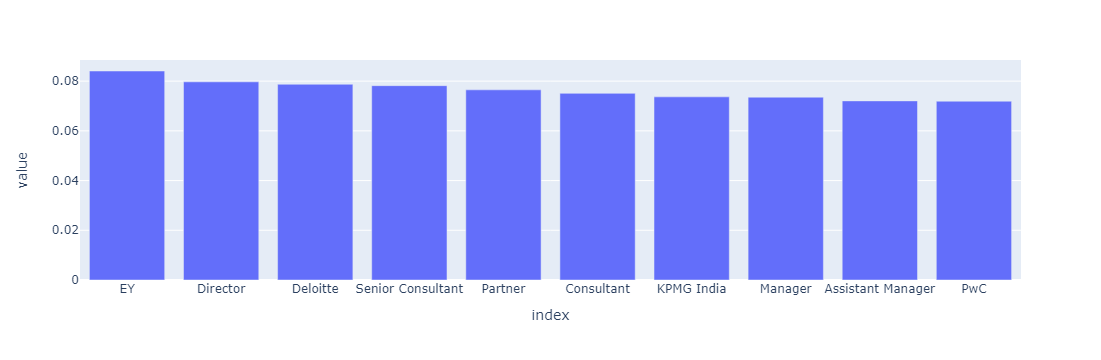

In [35]:
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])

fig = px.bar(closeness_df.sort_values('centrality', ascending=False).head(10))
fig.update_layout(showlegend=False)

The results of the betwenness and closeness centrality are the same with that of degree centrality. Let's add the centrality as attributes of our network.

In [36]:
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'between_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')


Sepearate the nodes of the network into communities using the community library.

In [37]:
communities = cl.best_partition(G)
communities

{'Director - Merchandising': 0,
 'Walmart': 0,
 'Recruiter': 0,
 'NEOSTATS': 0,
 'HR and Innovation Practice Lead(5G and 6G Technology)': 1,
 'Jio Platforms Ltd': 1,
 'Lt Gen Indian Army Veteran': 2,
 'Indian Army': 2,
 'Research Internship': 3,
 'IIT Kharagpur': 3,
 'Associate Partner': 4,
 'IBM': 4,
 'Strategy Senior Manager': 5,
 'Accenture': 5,
 'Hon. National President ': 6,
 'National HRD Network': 6,
 'Operation Director': 7,
 'Jabil': 7,
 'Partner and Vice President': 8,
 'Complete Circle Capital Pvt. Ltd.': 8,
 'Senior Manager': 9,
 'Indegene': 9,
 'Partner': 9,
 'EY': 0,
 'Management Consulting Analyst': 5,
 'Accenture Strategy': 5,
 'Associate Director': 9,
 'Deloitte': 9,
 'WSS - Pidilite Roff - Delhi': 10,
 'Roff ': 10,
 'President and Managing Director - Indian Subcontinent': 11,
 'SAP': 11,
 'Director': 0,
 'Manager': 9,
 'Director, Human Capital Consulting at Deloitte & Touche (M.E)': 9,
 'Manager - HR Transformation': 9,
 'Talent Development Manager': 9,
 'Marketing Re

The communities can also be added to the attributes of the network.

In [38]:
nx.set_node_attributes(G, communities, 'group')

Visualizing the network:

In [39]:
com_net = Network(notebook = True,
                  cdn_resources='remote',
                  width='1000px', 
                  height ='700px',
                  bgcolor='#222222', 
                  font_color='white')
com_net.from_nx(G)
com_net.show('LinkedIn_Network.html')

LinkedIn_Network.html


The network does show any clear cluster between the various communities. This means that there is a clear connection between the organizations and jobs in my network. But in periphery there are not many clear cooncetions between organizations and jobs. It shows that is my LinkedIn network is a moderately connected network.

We can measure this quantitatively through network transitivity or clustering coefficient of a network. The transitivity or clustering coefficient of a network is a measure of the tendency of the nodes to cluster together.

In [45]:
print(nx.transitivity(G))

0


This shows that there is zero probability of the network joining together.

## Summary
In this notebook, we had a quick overview of my network analysis using my LinkedIn data. Exploratory Data Analysis and Network analysis was employed which revealed that I need to become a bit more deliberate with my activities on LinkedIn as my network was shown to have moderate connections.  This was also supported by the fact that I have had a bit of slump in activity (connections) in recent period. 
The network analysis showed that there is a moderate relationship between my organisations and position they work for. This might be because my connections describe the same job with different words. Another reason is that I connect with different roles in the same companies. That is, my connections are not the result of a targeted effort. 


# Conclusion
   This notebook only gives a brief introduction to network analysis and graph theory.